In [15]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.utils import resample
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Load the dataset
file_path = "/kaggle/input/spam-or-not-spam-dataset/spam_or_not_spam.csv"
data = pd.read_csv(file_path)

# Data Preprocessing
# Balance the dataset by resampling (assuming 'label' column is 1 for spam and 0 for not spam)
spam_data = data[data['label'] == 1]
not_spam_data = data[data['label'] == 0]

# Resample to balance the dataset
# Resample the spam data with replacement to match the size of the not_spam_data
spam_resampled = resample(spam_data, replace=True, n_samples=len(not_spam_data), random_state=42)

# Concatenate the resampled spam data with the not_spam_data
balanced_data = pd.concat([not_spam_data, spam_resampled])

# Resample the not_spam data to match the size of the spam data
not_spam_resampled = resample(not_spam_data, replace=False, n_samples=len(spam_data), random_state=42)

# Concatenate the resampled not_spam data with the spam_data
balanced_data = pd.concat([spam_data, not_spam_resampled])


# Tokenization and Vectorization
def tokenize(text):
    # Convert the text to a string and then process
    if isinstance(text, str):
        return text.lower().split()
    else:
        return []  # Return an empty list for non-string entries (e.g., NaN)


balanced_data['tokens'] = balanced_data['email'].apply(tokenize)


# Create a vocabulary (list of unique words)
vocabulary = set()
for tokens in balanced_data['tokens']:
    vocabulary.update(tokens)

# Create a Word2Vec model using negative sampling
class Word2Vec:
    def __init__(self, vocabulary_size, embedding_size):
        self.vocabulary_size = vocabulary_size
        self.embedding_size = embedding_size
        self.W1 = np.random.randn(vocabulary_size, embedding_size)  # Word embeddings matrix
        self.W2 = np.random.randn(embedding_size, vocabulary_size)  # Context embeddings matrix
        
        # Initialize vocabulary
        self.vocabulary = {}

    def build_vocabulary(self, tokens):
        # Create a vocabulary from the tokens (mapping word -> index)
        unique_words = set([word for sublist in tokens for word in sublist])  # Flatten tokens
        self.vocabulary = {word: idx for idx, word in enumerate(unique_words)}

    def get_context(self, tokens, index, window_size=1):
        # Get the context words for a target word at position `index` in `tokens`
        context = []
        for i in range(max(0, index - window_size), min(len(tokens), index + window_size + 1)):
            if i != index:
                context.append(tokens[i])
        return context

    def word2vec_step(self, target_word, context_word):
        target_idx = self.vocabulary.get(target_word)
        context_idx = self.vocabulary.get(context_word)
        
        # One-hot encoding
        target_vec = self.W1[target_idx]  # Shape: (embedding_size,)
        context_vec = self.W2[:, context_idx]  # Shape: (embedding_size,)

        # Prediction (logistic regression)
        y_pred = self.sigmoid(np.dot(self.W1, context_vec))  # y_pred should have shape (vocabulary_size,)

        # Calculate error (difference between predicted and actual)
        error = y_pred - self.one_hot(context_idx)  # Error will have shape (vocabulary_size,)

        # Backpropagate: Gradient descent updates
        # Now update only for the current word (target_word) and context_word
        self.W1[target_idx] -= 0.1 * error[target_idx] * context_vec  # Update target word embedding
        self.W2[:, context_idx] -= 0.1 * error[target_idx] * target_vec  # Update context word embeddings
        
        return -np.log(y_pred[context_idx])  # Return the loss for this context word

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def one_hot(self, idx):
        # Generate a one-hot encoded vector for the context word
        one_hot = np.zeros(self.vocabulary_size)
        one_hot[idx] = 1
        return one_hot

    def train(self, data, epochs=10):
        self.build_vocabulary(data)  # Build the vocabulary from the tokens
        total_loss = 0
        
        for epoch in range(epochs):
            for sentence in data:
                for i, target_word in enumerate(sentence):
                    context = self.get_context(sentence, i)
                    for context_word in context:
                        loss = self.word2vec_step(target_word, context_word)
                        total_loss += loss
            print(f"Epoch {epoch + 1}, Loss: {total_loss}")


# Create a vocabulary index (map word to index)
vocabulary_index = {word: idx for idx, word in enumerate(vocabulary)}

# Train the Word2Vec model
model = Word2Vec(vocabulary_size=len(set([word for sentence in tokens for word in sentence])), embedding_size=10)
model.train(tokens, epochs=50)

# Save the embeddings (W1)
np.save("word_embeddings.npy", model.W1)

# Load embeddings for use in the neural network notebook
word_embeddings = np.load("word_embeddings.npy")


Epoch 1, Loss: 769.3057100828097
Epoch 2, Loss: 1576.279077140417
Epoch 3, Loss: 2562.466370841682
Epoch 4, Loss: 3680.4777915341774
Epoch 5, Loss: 4897.967382366456
Epoch 6, Loss: 6192.309885387286
Epoch 7, Loss: 7549.296073939487
Epoch 8, Loss: 8959.804448215318
Epoch 9, Loss: 10417.228699991912
Epoch 10, Loss: 11916.439134581527
Epoch 11, Loss: 13453.314637813044
Epoch 12, Loss: 15024.468639994377
Epoch 13, Loss: 16627.068894912638
Epoch 14, Loss: 18258.712432319277
Epoch 15, Loss: 19917.33561524756
Epoch 16, Loss: 21601.147639302228
Epoch 17, Loss: 23308.58026039775
Epoch 18, Loss: 25038.249080401038
Epoch 19, Loss: 26788.923256662296
Epoch 20, Loss: 28559.50147149615
Epoch 21, Loss: 30348.99263195915
Epoch 22, Loss: 32156.500196937366
Epoch 23, Loss: 33981.209322407456
Epoch 24, Loss: 35822.37622221409
Epoch 25, Loss: 37679.31928934849
Epoch 26, Loss: 39551.41162993258
Epoch 27, Loss: 41438.074741063014
Epoch 28, Loss: 43338.77312255005
Epoch 29, Loss: 45253.009657004404
Epoch 30,

Epoch 1, Loss: 901.3606104804244
Epoch 2, Loss: 1675.849560810147
Epoch 3, Loss: 2552.7389902652826
Epoch 4, Loss: 3552.519819247809
Epoch 5, Loss: 4661.828641321958
Epoch 6, Loss: 5860.797111529666
Epoch 7, Loss: 7132.088121968949
Epoch 8, Loss: 8464.132274189546
Epoch 9, Loss: 9848.785760262032
Epoch 10, Loss: 11279.875338651042
Epoch 11, Loss: 12752.529413157692
Epoch 12, Loss: 14262.798095824173
Epoch 13, Loss: 15807.412445449336
Epoch 14, Loss: 17383.622103119786
Epoch 15, Loss: 18989.081120221857
Epoch 16, Loss: 20621.765113145473
Epoch 17, Loss: 22279.909616493085
Epoch 18, Loss: 23961.96323753529
Epoch 19, Loss: 25666.551413857997
Epoch 20, Loss: 27392.447933564257
Epoch 21, Loss: 29138.5522460779
Epoch 22, Loss: 30903.871164277723
Epoch 23, Loss: 32687.503945861212
Epoch 24, Loss: 34488.63000936988
Epoch 25, Loss: 36306.49872876107
Epoch 26, Loss: 38140.42088545776
Epoch 27, Loss: 39989.76145508418
Epoch 28, Loss: 41853.933478625135
Epoch 29, Loss: 43732.392821956724
Epoch 30,

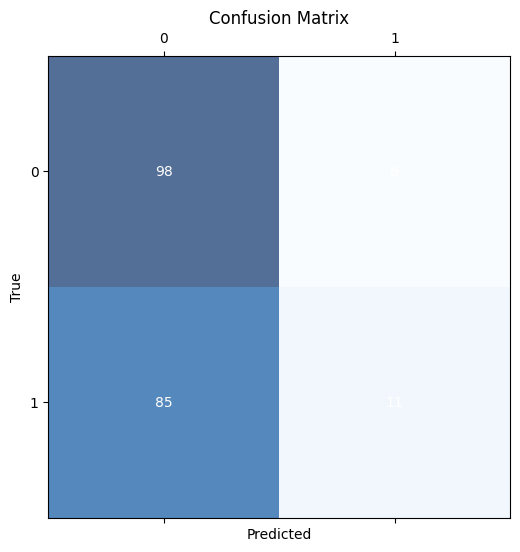

In [22]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.utils import resample
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Load the dataset
file_path = "/kaggle/input/spam-or-not-spam-dataset/spam_or_not_spam.csv"
data = pd.read_csv(file_path)

# Data Preprocessing
# Balance the dataset by resampling (assuming 'label' column is 1 for spam and 0 for not spam)
spam_data = data[data['label'] == 1]
not_spam_data = data[data['label'] == 0]

# Resample to balance the dataset
# Resample the spam data with replacement to match the size of the not_spam_data
spam_resampled = resample(spam_data, replace=True, n_samples=len(not_spam_data), random_state=42)

# Concatenate the resampled spam data with the not_spam_data
balanced_data = pd.concat([not_spam_data, spam_resampled])

# Resample the not_spam data to match the size of the spam data
not_spam_resampled = resample(not_spam_data, replace=False, n_samples=len(spam_data), random_state=42)

# Concatenate the resampled not_spam data with the spam_data
balanced_data = pd.concat([spam_data, not_spam_resampled])


# Tokenization and Vectorization
def tokenize(text):
    # Convert the text to a string and then process
    if isinstance(text, str):
        return text.lower().split()
    else:
        return []  # Return an empty list for non-string entries (e.g., NaN)


balanced_data['tokens'] = balanced_data['email'].apply(tokenize)


# Create a vocabulary (list of unique words)
vocabulary = set()
for tokens in balanced_data['tokens']:
    vocabulary.update(tokens)

# Create a Word2Vec model using negative sampling
class Word2Vec:
    def __init__(self, vocabulary_size, embedding_size):
        self.vocabulary_size = vocabulary_size
        self.embedding_size = embedding_size
        self.W1 = np.random.randn(vocabulary_size, embedding_size)  # Word embeddings matrix
        self.W2 = np.random.randn(embedding_size, vocabulary_size)  # Context embeddings matrix
        
        # Initialize vocabulary
        self.vocabulary = {}

    def build_vocabulary(self, tokens):
        # Create a vocabulary from the tokens (mapping word -> index)
        unique_words = set([word for sublist in tokens for word in sublist])  # Flatten tokens
        self.vocabulary = {word: idx for idx, word in enumerate(unique_words)}

    def get_context(self, tokens, index, window_size=1):
        # Get the context words for a target word at position `index` in `tokens`
        context = []
        for i in range(max(0, index - window_size), min(len(tokens), index + window_size + 1)):
            if i != index:
                context.append(tokens[i])
        return context

    def word2vec_step(self, target_word, context_word):
        target_idx = self.vocabulary.get(target_word)
        context_idx = self.vocabulary.get(context_word)
        
        # One-hot encoding
        target_vec = self.W1[target_idx]  # Shape: (embedding_size,)
        context_vec = self.W2[:, context_idx]  # Shape: (embedding_size,)

        # Prediction (logistic regression)
        y_pred = self.sigmoid(np.dot(self.W1, context_vec))  # y_pred should have shape (vocabulary_size,)

        # Calculate error (difference between predicted and actual)
        error = y_pred - self.one_hot(context_idx)  # Error will have shape (vocabulary_size,)

        # Backpropagate: Gradient descent updates
        # Now update only for the current word (target_word) and context_word
        self.W1[target_idx] -= 0.1 * error[target_idx] * context_vec  # Update target word embedding
        self.W2[:, context_idx] -= 0.1 * error[target_idx] * target_vec  # Update context word embeddings
        
        return -np.log(y_pred[context_idx])  # Return the loss for this context word

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def one_hot(self, idx):
        # Generate a one-hot encoded vector for the context word
        one_hot = np.zeros(self.vocabulary_size)
        one_hot[idx] = 1
        return one_hot

    def train(self, data, epochs=10):
        self.build_vocabulary(data)  # Build the vocabulary from the tokens
        total_loss = 0
        
        for epoch in range(epochs):
            for sentence in data:
                for i, target_word in enumerate(sentence):
                    context = self.get_context(sentence, i)
                    for context_word in context:
                        loss = self.word2vec_step(target_word, context_word)
                        total_loss += loss
            print(f"Epoch {epoch + 1}, Loss: {total_loss}")


# Create a vocabulary index (map word to index)
vocabulary_index = {word: idx for idx, word in enumerate(vocabulary)}

# Train the Word2Vec model
model = Word2Vec(vocabulary_size=len(set([word for sentence in tokens for word in sentence])), embedding_size=10)
model.train(tokens, epochs=50)

# Save the embeddings (W1)
np.save("word_embeddings.npy", model.W1)

# Load embeddings for use in the neural network notebook
word_embeddings = np.load("word_embeddings.npy")

# Save the embeddings (W1)
word_embeddings = model.W1

# Get the average embedding for each email (simple averaging of word embeddings)
def get_email_embedding(tokens):
    embeddings = []
    for word in tokens:
        # Check if the word exists in the vocabulary index
        if word in vocabulary_index:
            index = vocabulary_index[word]
            # Ensure the index is within bounds
            if index < len(word_embeddings):
                embeddings.append(word_embeddings[index])
    # If no valid embeddings, return a vector of zeros
    return np.mean(embeddings, axis=0) if embeddings else np.zeros(word_embeddings.shape[1])

balanced_data['email_embeddings'] = balanced_data['tokens'].apply(get_email_embedding)


# Split data into training and testing sets
X = np.array(list(balanced_data['email_embeddings']))
y = balanced_data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features (important for some classifiers)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train a classifier (Logistic Regression)
classifier = LogisticRegression(random_state=42)
classifier.fit(X_train, y_train)

# Predictions and Evaluation
y_pred = classifier.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Plot Confusion Matrix
fig, ax = plt.subplots(figsize=(6, 6))
ax.matshow(cm, cmap='Blues', alpha=0.7)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='white')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


Epoch 1, Loss: 0.32200188519645123
Epoch 101, Loss: 0.10492589527825882
Epoch 201, Loss: 0.05779010537272473
Epoch 301, Loss: 0.04610319310243958
Epoch 401, Loss: 0.03948766272393964
Epoch 501, Loss: 0.032772634983685725
Epoch 601, Loss: 0.02912522945763823
Epoch 701, Loss: 0.02380883756581612
Epoch 801, Loss: 0.021716270334191583
Epoch 901, Loss: 0.019630188893882967
Neural Network model saved.
Accuracy: 0.9780
Precision: 0.9811
Recall: 0.9729
F1 Score: 0.9769


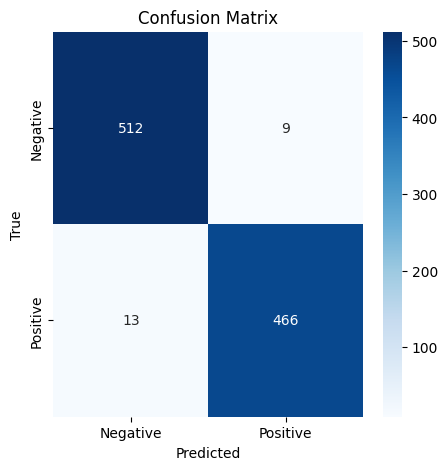

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Neural Network class
class FeedForwardNN:
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        # Initialize weights
        self.W1 = np.random.randn(input_size, hidden_size)
        self.b1 = np.zeros(hidden_size)
        self.W2 = np.random.randn(hidden_size, output_size)
        self.b2 = np.zeros(output_size)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        return x * (1 - x)

    def forward(self, X):
        self.hidden = self.sigmoid(np.dot(X, self.W1) + self.b1)
        self.output = self.sigmoid(np.dot(self.hidden, self.W2) + self.b2)
        return self.output

    def backward(self, X, y, learning_rate=0.1):
        output_error = y - self.output
        output_delta = output_error * self.sigmoid_derivative(self.output)

        hidden_error = output_delta.dot(self.W2.T)
        hidden_delta = hidden_error * self.sigmoid_derivative(self.hidden)

        self.W2 += self.hidden.T.dot(output_delta) * learning_rate
        self.b2 += np.sum(output_delta, axis=0) * learning_rate
        self.W1 += X.T.dot(hidden_delta) * learning_rate
        self.b1 += np.sum(hidden_delta, axis=0) * learning_rate

    def train(self, X, y, epochs=1000, learning_rate=0.1):
        for epoch in range(epochs):
            self.forward(X)
            self.backward(X, y, learning_rate)
            if epoch % 100 == 0:
                loss = np.mean(np.square(y - self.output))
                print(f"Epoch {epoch + 1}, Loss: {loss}")

    def predict(self, X):
        return self.forward(X)

# Example: Creating synthetic data for the neural network
X_train = np.random.randn(1000, 120)  # 1000 samples, 12 words * 10 embedding size
y_train = np.random.randint(0, 2, (1000, 1))  # Binary labels

# Initialize and train the neural network
nn = FeedForwardNN(input_size=120, hidden_size=8, output_size=1)
nn.train(X_train, y_train, epochs=1000, learning_rate=0.1)

# Save the model parameters
np.save('nn_weights.npy', {'W1': nn.W1, 'b1': nn.b1, 'W2': nn.W2, 'b2': nn.b2})
print("Neural Network model saved.")

# Evaluate the model
y_pred = nn.predict(X_train)
y_pred_binary = (y_pred > 0.5).astype(int)

# Model evaluation metrics
accuracy = accuracy_score(y_train, y_pred_binary)
precision = precision_score(y_train, y_pred_binary)
recall = recall_score(y_train, y_pred_binary)
f1 = f1_score(y_train, y_pred_binary)

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion matrix
cm = confusion_matrix(y_train, y_pred_binary)

# Plot confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
